In [1]:
%load_ext autoreload
%autoreload 2

import os 
# Set the environment for R
if os.environ.get('HOME') == '/home/tom':
    os.environ['R_HOME'] = '/home/tom/miniconda3/envs/octagon_analysis/lib/R'  # Lab desktop
elif os.environ.get('HOME') == 1:
    os.environ['R_HOME']= r'C:\Users\tomha\miniconda3\envs\octagon_analysis\lib\R'  # Laptop
elif os.environ.get('HOME') == 2:
    os.environ['R_HOME']=r'D:\Users\Tom\miniconda3\envs\octagon_analysis\lib\R'       # Home desktop
# elif:
    # append other machines here


import rpy2

import rpy2.robjects as robjects
print(robjects.r('R.version.string'))

import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import globals
import data_strings
import data_extraction.get_indices as get_indices
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
from trajectory_analysis import trajectory_vectors
from plotting import plot_octagon
import parse_data.identify_filepaths as identify_filepaths 
from data_extraction.trial_list_filters import filter_trials_other_visible
from analysis import opponent_visibility
from ipywidgets import IntProgress
from IPython.display import display
import time
from pymer4.models import Lmer


[1] "R version 4.3.3 (2024-02-29)"



In [2]:
os.getcwd()

'/home/tom/repos/octagon_analysis/sandbox/glm'

## Solos

In [59]:
# load solo data from left-one-out cross-validation
data_folder = os.path.join('..','data', 'k_fold_CV', '3levels-firstseenwall-bobyqa')

CV_dataset_names = [
    file for file in os.listdir(data_folder) if file.startswith('20-fold-CV_results_solo_') and file.endswith('.pickle')
]
print(CV_dataset_names)

ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[-2], CV_dataset_names[1], CV_dataset_names[-3], CV_dataset_names[-1]]
# ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[1], CV_dataset_names[2],  CV_dataset_names[6], CV_dataset_names[3], CV_dataset_names[4], CV_dataset_names[5], CV_dataset_names[7]  ]
# ordered_datasets_names = [CV_dataset_names[-4], CV_dataset_names[2], CV_dataset_names[1], CV_dataset_names[0], CV_dataset_names[-1]]
# ordered_datasets_names = CV_dataset_names

print(ordered_datasets_names)


cross_validation_datasets = [pd.read_pickle(os.path.join(data_folder, file)) for file in ordered_datasets_names
]


['20-fold-CV_results_solo_randomintercepts_onlydistance.pickle', '20-fold-CV_results_solo_randomintercepts.pickle', '20-fold-CV_results_solo_randomintercepts_distancesinteraction.pickle', '20-fold-CV_results_solo_randomintercepts_distancepluswallsep.pickle', '20-fold-CV_results_solo_randomintercepts_distancesandwallsepinteraction.pickle']
['20-fold-CV_results_solo_randomintercepts_onlydistance.pickle', '20-fold-CV_results_solo_randomintercepts_distancepluswallsep.pickle', '20-fold-CV_results_solo_randomintercepts.pickle', '20-fold-CV_results_solo_randomintercepts_distancesinteraction.pickle', '20-fold-CV_results_solo_randomintercepts_distancesandwallsepinteraction.pickle']


In [60]:
cross_validation_datasets[3]['model_formula']

'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + D2H:FirstSeenWall + D2L:FirstSeenWall + (1|GlmPlayerID)'

In [61]:
# find k
k = len(cross_validation_datasets[0]['split_df'])
print(f"{k} folds")

20 folds


In [62]:
# create plotting names
plotting_names = [
    'model 1',
    'model 2',
    'model 3',
    'model 4',
    'model 5'
]

In [63]:
cross_validation_datasets[0].keys()

dict_keys(['name', 'model_formula', 'split_df', 'num_folds', 'predictions', 'predict_data', 'fold_nlls', 'average_nll'])

In [64]:
# extract and process nll
nlls = [ dataset['fold_nlls'] for dataset in cross_validation_datasets]

# divide nll by the number of models
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]

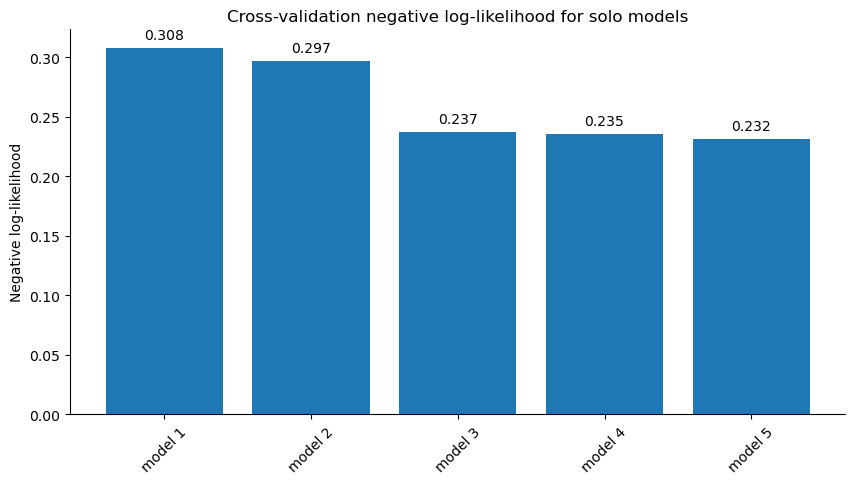

In [65]:
# plot nll barplot
plt.figure(figsize=(10, 5))
plt.bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')
plt.title('Cross-validation negative log-likelihood for solo models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Add values above bars
for i, value in enumerate(average_nlls):
    plt.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# plt.tight_layout()

In [66]:
from scipy.stats import ttest_rel
from itertools import combinations

# Get all pairwise combinations of indices
pairs = list(combinations(range(len(nlls)), 2))
num_comparisons = len(pairs)
print(f"Number of pairwise comparisons: {num_comparisons}")

# Bonferroni-corrected significance level
alpha = 0.05 / num_comparisons

# Run paired t-tests and report results
results = []
for i, j in pairs:
    t_stat, p_val = ttest_rel(nlls[i], nlls[j])
    significant = p_val < alpha
    results.append((i, j, t_stat, p_val, significant))
    print(f"Model {i+1} vs Model {j+1}: t = {t_stat:.3f}, p = {p_val:.4f}, significant (Bonferroni) = {significant}")

print(f"Bonferroni-corrected significance level: {alpha:.4f}")

Number of pairwise comparisons: 10
Model 1 vs Model 2: t = 5.992, p = 0.0000, significant (Bonferroni) = True
Model 1 vs Model 3: t = 14.179, p = 0.0000, significant (Bonferroni) = True
Model 1 vs Model 4: t = 14.406, p = 0.0000, significant (Bonferroni) = True
Model 1 vs Model 5: t = 15.174, p = 0.0000, significant (Bonferroni) = True
Model 2 vs Model 3: t = 12.796, p = 0.0000, significant (Bonferroni) = True
Model 2 vs Model 4: t = 12.672, p = 0.0000, significant (Bonferroni) = True
Model 2 vs Model 5: t = 12.979, p = 0.0000, significant (Bonferroni) = True
Model 3 vs Model 4: t = 1.593, p = 0.1275, significant (Bonferroni) = False
Model 3 vs Model 5: t = 2.873, p = 0.0097, significant (Bonferroni) = False
Model 4 vs Model 5: t = 2.995, p = 0.0074, significant (Bonferroni) = False
Bonferroni-corrected significance level: 0.0050


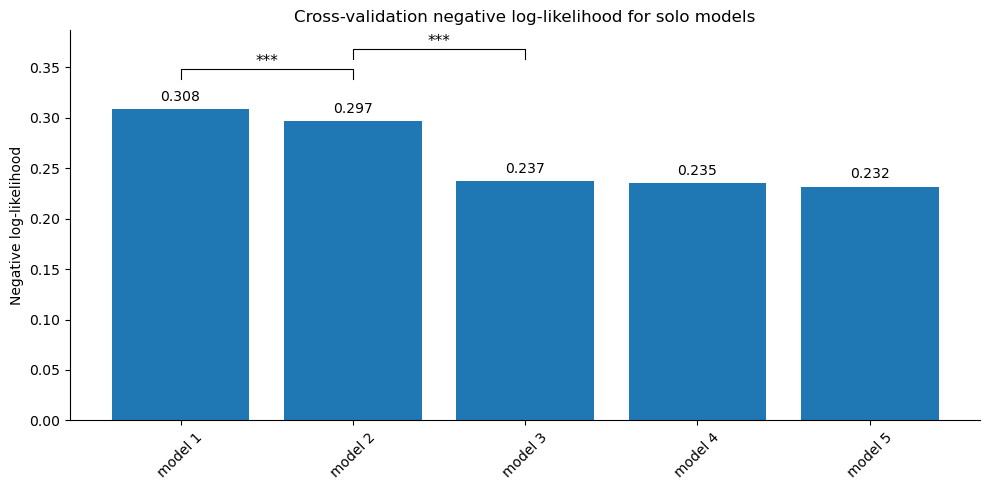

In [67]:
# Plot bar chart of average_nlls with significance markers for only the smallest significant difference per model

# Define significant_pairs: pairs where the Bonferroni-corrected test is significant
significant_pairs = [pair for pair, res in zip(pairs, results) if res[4]]

plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')

plt.title('Cross-validation negative log-likelihood for solo models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add values above bars
for i, value in enumerate(average_nlls):
    plt.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# Mark only the smallest significant difference for each model (compared to models with lower nll)
y_max = max(average_nlls)
h = 0.01  # height of significance lines
vspace = 0.02  # increased vertical spacing between significance bars

# For each model, find the smallest significant difference to a model with lower nll
shown_pairs = set()
for i in range(len(average_nlls)):
    # Only consider comparisons to models with lower nll
    lower_models = [j for j in range(len(average_nlls)) if average_nlls[j] < average_nlls[i]]
    min_diff = None
    min_j = None
    min_p = None
    for j in lower_models:
        # Check if (i, j) or (j, i) is a significant pair
        if (i, j) in significant_pairs:
            res_idx = pairs.index((i, j))
            diff = average_nlls[i] - average_nlls[j]
            if min_diff is None or diff < min_diff:
                min_diff = diff
                min_j = j
                min_p = results[res_idx][3]
        elif (j, i) in significant_pairs:
            res_idx = pairs.index((j, i))
            diff = average_nlls[i] - average_nlls[j]
            if min_diff is None or diff < min_diff:
                min_diff = diff
                min_j = j
                min_p = results[res_idx][3]
    if min_j is not None and (min_j, i) not in shown_pairs and (i, min_j) not in shown_pairs:
        # Determine asterisk level
        if min_p < alpha / 100:
            stars = '***'
        elif min_p < alpha / 10:
            stars = '**'
        else:
            stars = '*'
        x1, x2 = i, min_j
        y = y_max + h + 0.02 + len(shown_pairs) * vspace
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=0.8, c='k')
        plt.text((x1 + x2) / 2, y + h, stars, ha='center', va='bottom', color='k', fontsize=11)
        shown_pairs.add((i, min_j))
plt.tight_layout()
plt.show()

In [68]:
from scipy.stats import ttest_rel
from itertools import combinations

def plot_nlls_with_significance(average_nlls, plotting_names, results, pairs, bonferroni_alpha, title1, title2):
    """
    Plots two subplots:
    1. Barplot of average_nlls.
    2. Barplot of average_nlls with significance markers for smallest significant difference per model.
    """
    import matplotlib.pyplot as plt

    # First subplot: plain barplot
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    axs[0].bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
    axs[0].set_ylabel('Negative log-likelihood')
    axs[0].set_title(title1)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    for i, value in enumerate(average_nlls):
        axs[0].text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    # Second subplot: with significance markers
    bars = axs[1].bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
    axs[1].set_ylabel('Negative log-likelihood')
    axs[1].set_title(title2)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    for i, value in enumerate(average_nlls):
        axs[1].text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    # Add significance markers
    significant_pairs = [pair for pair, res in zip(pairs, results) if res[4]]
    y_max = max(average_nlls)
    h = 0.02
    vspace = 0.05
    shown_pairs = set()
    for i in range(len(average_nlls)):
        lower_models = [j for j in range(len(average_nlls)) if average_nlls[j] < average_nlls[i]]
        min_diff = None
        min_j = None
        min_p = None
        for j in lower_models:
            if (i, j) in significant_pairs:
                res_idx = pairs.index((i, j))
                diff = average_nlls[i] - average_nlls[j]
                if min_diff is None or diff < min_diff:
                    min_diff = diff
                    min_j = j
                    min_p = results[res_idx][3]
            elif (j, i) in significant_pairs:
                res_idx = pairs.index((j, i))
                diff = average_nlls[i] - average_nlls[j]
                if min_diff is None or diff < min_diff:
                    min_diff = diff
                    min_j = j
                    min_p = results[res_idx][3]
        if min_j is not None and (min_j, i) not in shown_pairs and (i, min_j) not in shown_pairs:
            if min_p < bonferroni_alpha / 100:
                stars = '***'
            elif min_p < bonferroni_alpha / 10:
                stars = '**'
            else:
                stars = '*'
            x1, x2 = i, min_j
            y = y_max + h + 0.02 + len(shown_pairs) * vspace
            axs[1].plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=0.8, c='k')
            axs[1].text((x1 + x2) / 2, y + h, stars, ha='center', va='bottom', color='k', fontsize=11)
            shown_pairs.add((i, min_j))
    plt.tight_layout()
    plt.show()

def run_pairwise_ttests(nlls, alpha=0.05):
    """
    Runs all pairwise t-tests between models' nlls and returns results.
    """

    pairs = list(combinations(range(len(nlls)), 2))
    num_comparisons = len(pairs)
    bonferroni_alpha = alpha / num_comparisons

    results = []
    for i, j in pairs:
        t_stat, p_val = ttest_rel(nlls[i], nlls[j])
        significant = p_val < bonferroni_alpha
        results.append((i, j, t_stat, p_val, significant))
    return results, pairs, bonferroni_alpha

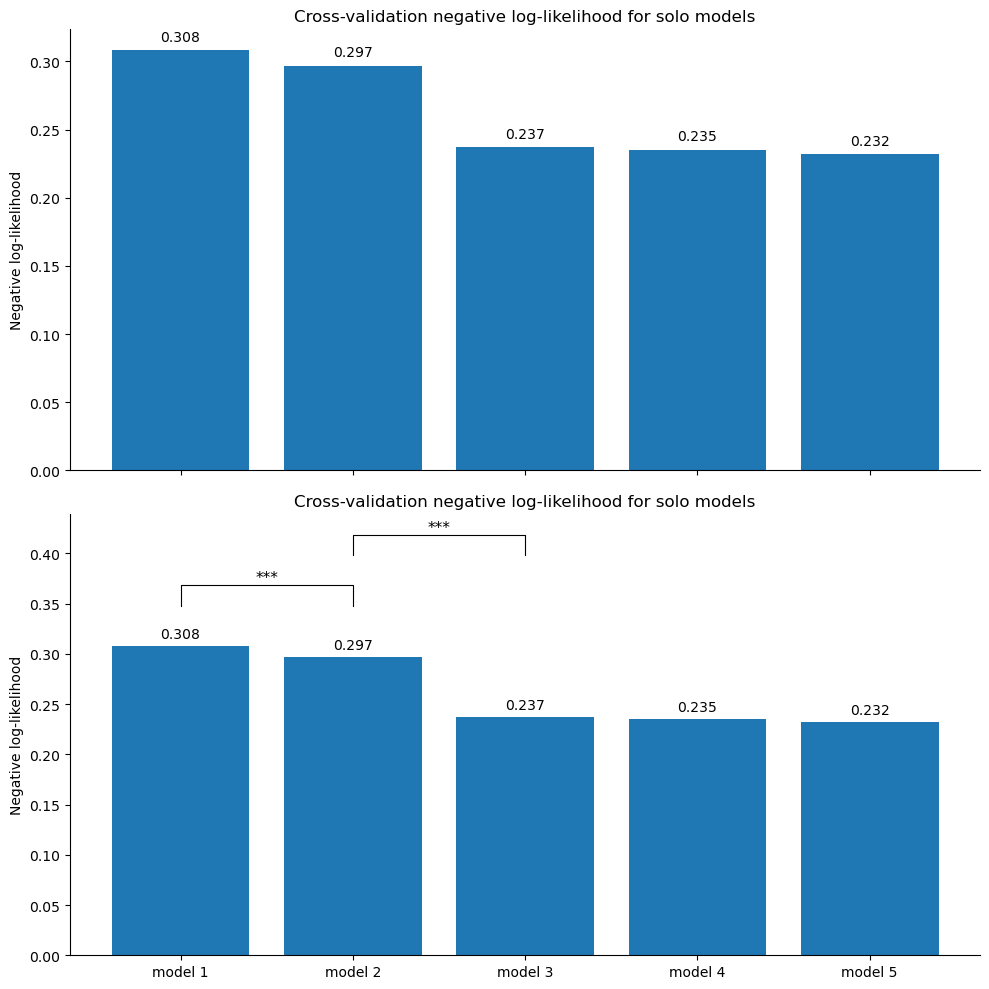

In [69]:
pairs = list(combinations(range(len(nlls)), 2))
num_comparisons = len(pairs)
# Bonferroni-corrected significance level
bonferroni_alpha = 0.05 / num_comparisons
title1 = 'Cross-validation negative log-likelihood for solo models'

results, pairs, bonferroni_alpha = run_pairwise_ttests(nlls, alpha=0.05)
plot_nlls_with_significance(average_nlls, plotting_names, results, pairs, bonferroni_alpha, title1, title2=title1)

In [70]:
np.array(cross_validation_datasets[3]['predictions'][0]).shape[0], np.array(cross_validation_datasets[3]['predict_data'][0]).shape[0]




(274, 274)

In [71]:
cross_validation_datasets[0]['name']

'solo_randomintercepts_onlydistance'

In [72]:
# get prediction and ground truth data for each of the models in cross_validation_datasets
prediction_data = [cross_validation_datasets[i]['predictions'] for i in range(len(cross_validation_datasets))]
ground_truth_data = [cross_validation_datasets[i]['predict_data'] for i in range(len(cross_validation_datasets))]


# concatenate across the folds to produce a single predictions and ground truth df for each model
for i, model_predictions in enumerate(prediction_data):
    prediction_data[i] = np.concatenate(model_predictions)

for i, model_ground_truth in enumerate(ground_truth_data):
    ground_truth_data[i] = np.concatenate(list(fold['ChooseHigh'].values for fold in model_ground_truth))




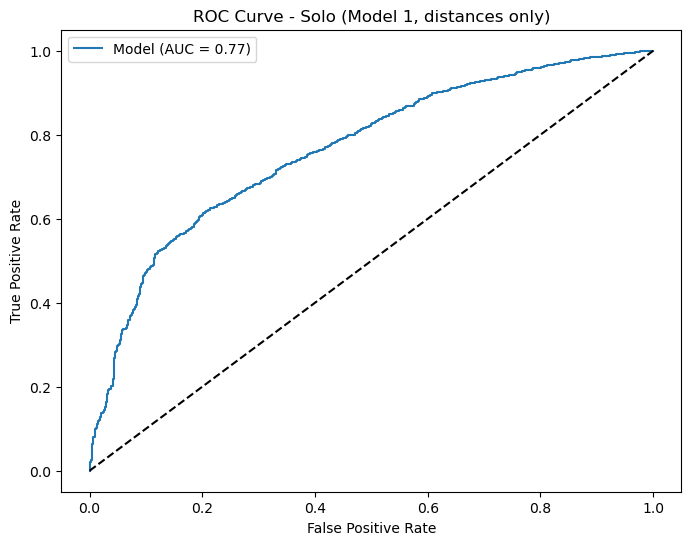

In [83]:
from sklearn.metrics import roc_curve, auc

# Example: Assuming `y_true` is the true labels and `y_scores` are model predictions
fpr, tpr, _ = roc_curve(ground_truth_data[0], prediction_data[0])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Solo (Model 1, distances only)')
plt.legend()
plt.show()

### Testing significance of nlls differences between models

In [18]:
model1 = cross_validation_datasets[-3]
model2 = cross_validation_datasets[-1]

from scipy.stats import ttest_rel
# Perform paired t-test between two models
t_stat, p_value = ttest_rel(model1['fold_nlls'], model2['fold_nlls'])
print(f"Paired t-test between Model 1 and Model 2: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

Paired t-test between Model 1 and Model 2: t-statistic = 2.873, p-value = 0.010


## Solo-social

In [19]:
# load solo-social data from left-one-out cross-validation
data_folder = os.path.join('..','data', 'k_fold_CV')

CV_dataset_names = [
    file for file in os.listdir(data_folder) if file.startswith('20-fold-CV_results_solosocial') and file.endswith('.pickle')
]
print(CV_dataset_names)

# ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[2], CV_dataset_names[3], CV_dataset_names[4], CV_dataset_names[2]]
ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[1], CV_dataset_names[2], CV_dataset_names[3]]


print(ordered_datasets_names)


cross_validation_datasets = [pd.read_pickle(os.path.join(data_folder, file)) for file in ordered_datasets_names
]


[]


IndexError: list index out of range

In [20]:
# find k
k = len(cross_validation_datasets[0]['split_df'])
print(f"{k} folds")

20 folds


In [21]:
# create plotting names
plotting_names = [
    'model 1',
    'model 2',
    'model 3',
    'model 4'
]

In [22]:
cross_validation_datasets[0]['split_df'][0]['FirstSeenWall'].unique()

['2.0', '1.0', '3.0', NaN]
Categories (3, object): ['1.0', '2.0', '3.0']

In [23]:
len(average_nlls)

5

In [24]:
# extract and process nll
nlls = [ dataset['nll'] for dataset in cross_validation_datasets]

# divide nll by the number of models
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]

KeyError: 'nll'

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (4,)  and requested shape (5,)

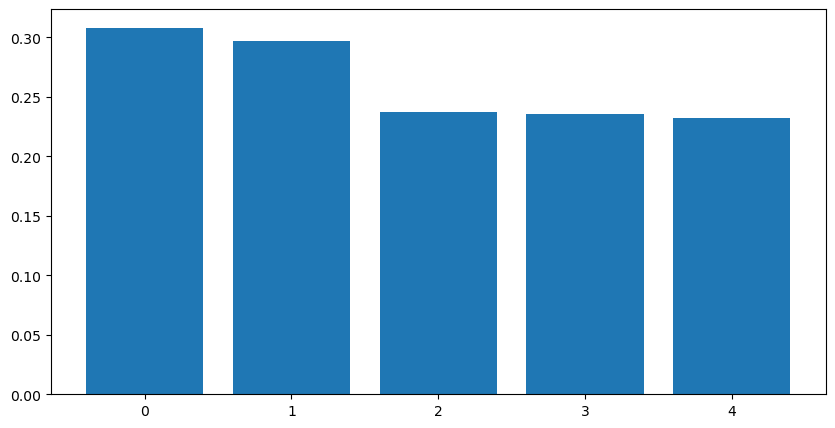

In [25]:
# plot nll barplot

plt.figure(figsize=(10, 5))
plt.bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')
plt.title('Cross-validation negative log-likelihood for solo-social models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Add values above bars
for i, value in enumerate(average_nlls):
    plt.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# plt.tight_layout()

In [26]:
cross_validation_datasets[0]["model_formula"]

'ChooseHigh ~ 1 + D2H + D2L + (1|GlmPlayerID)'

In [27]:
# get prediction and ground truth data for each of the models in cross_validation_datasets
prediction_data = [cross_validation_datasets[i]['predictions'] for i in range(len(cross_validation_datasets))]
ground_truth_data = [cross_validation_datasets[i]['split_df'] for i in range(len(cross_validation_datasets))]


# concatenate across the folds to produce a single predictions and ground truth df for each model
for i, model_predictions in enumerate(prediction_data):
    prediction_data[i] = np.concatenate(model_predictions)

for i, model_ground_truth in enumerate(ground_truth_data):
    ground_truth_data[i] = np.concatenate(list(fold['ChooseHigh'].values for fold in model_ground_truth))




In [28]:
ground_truth_data[0]

array([1., 1., 1., ..., 1., 1., 1.], shape=(5544,))

In [29]:
from sklearn.metrics import roc_curve, auc

# remove elements from datasets if ground truth is NaN
for i in range(len(ground_truth_data)):
    mask = ~np.isnan(ground_truth_data[i])
    ground_truth_data[i] = ground_truth_data[i][mask]
    prediction_data[i] = prediction_data[i][mask]

# Example: Assuming `y_true` is the true labels and `y_scores` are model predictions
fpr, tpr, _ = roc_curve(ground_truth_data[1], prediction_data[1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Solo-Social (Model 2, solo fixed effects model + SocialContext)') 
plt.legend()
plt.show()

IndexError: boolean index did not match indexed array along axis 0; size of axis is 5436 but size of corresponding boolean axis is 5544

## Social

In [104]:
# load social data from left-one-out cross-validation
data_folder = os.path.join('..','data', 'k_fold_CV', '3levels-firstseenwall-bobyqa')

CV_dataset_names = [
    file for file in os.listdir(data_folder) if file.startswith('20-fold-CV_results_social') and file.endswith('.pickle')
]
print(CV_dataset_names)

ordered_datasets_names = [CV_dataset_names[3], CV_dataset_names[2], CV_dataset_names[4], CV_dataset_names[6], CV_dataset_names[5], CV_dataset_names[1], CV_dataset_names[0]]
# ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[-1], CV_dataset_names[1], CV_dataset_names[2]]


print(ordered_datasets_names)


cross_validation_datasets = [pd.read_pickle(os.path.join(data_folder, file)) for file in ordered_datasets_names
]


['20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance_opponentfirstseen_distance-interactions.pickle', '20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance_opponentfirstseen_solo-and-social-interactions.pickle', '20-fold-CV_results_social_randomintercepts_no-opponentvisible.pickle', '20-fold-CV_results_social_randomintercepts_opponentvisible.pickle', '20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance.pickle', '20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance_opponentfirstseen_solointeractions.pickle', '20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance_opponentfirstseen.pickle']
['20-fold-CV_results_social_randomintercepts_opponentvisible.pickle', '20-fold-CV_results_social_randomintercepts_no-opponentvisible.pickle', '20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance.pickle', '20-fold-CV_results_social_randomintercept

In [105]:
# find k
k = len(cross_validation_datasets[0]['split_df'])
print(f"{k} folds")

20 folds


In [108]:
# create plotting names
plotting_names = [
    'model 1',
    'model 2',
    'model 3',
    'model 4',
    'model 5',
    'model 6',
    'model 7'
]

In [109]:
# extract and process nll
nlls = [ dataset['fold_nlls'] for dataset in cross_validation_datasets]

# divide nll by the number of models
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]

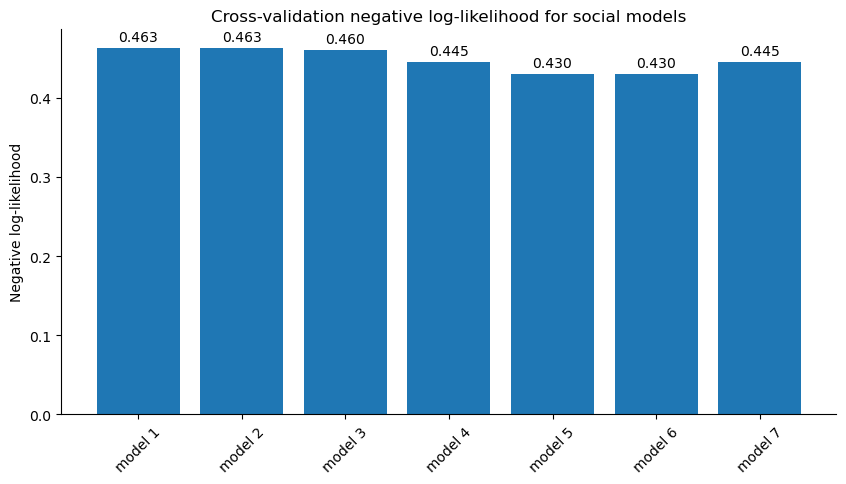

In [110]:
# plot nll barplot
plt.figure(figsize=(10, 5))
plt.bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')
plt.title('Cross-validation negative log-likelihood for social models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Add values above bars
for i, value in enumerate(average_nlls):
    plt.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# plt.tight_layout()

In [89]:
cross_validation_datasets[1]["predict_data"][0].isna().sum()

SessionID                 0
PlayerID                  0
GlmPlayerID               0
ChooseHigh                0
WallSep                   0
FirstSeenWall             0
D2H                       0
D2L                       0
OpponentVisible           0
OpponentFirstSeenWall    85
OpponentD2H               0
OpponentD2L               0
dtype: int64

In [90]:
# get prediction and ground truth data for each of the models in cross_validation_datasets
prediction_data = [cross_validation_datasets[i]['predictions'] for i in range(len(cross_validation_datasets))]
ground_truth_data = [cross_validation_datasets[i]['predict_data'] for i in range(len(cross_validation_datasets))]


# concatenate across the folds to produce a single predictions and ground truth df for each model
for i, model_predictions in enumerate(prediction_data):
    prediction_data[i] = np.concatenate(model_predictions)

for i, model_ground_truth in enumerate(ground_truth_data):
    ground_truth_data[i] = np.concatenate(list(fold['ChooseHigh'].values for fold in model_ground_truth))




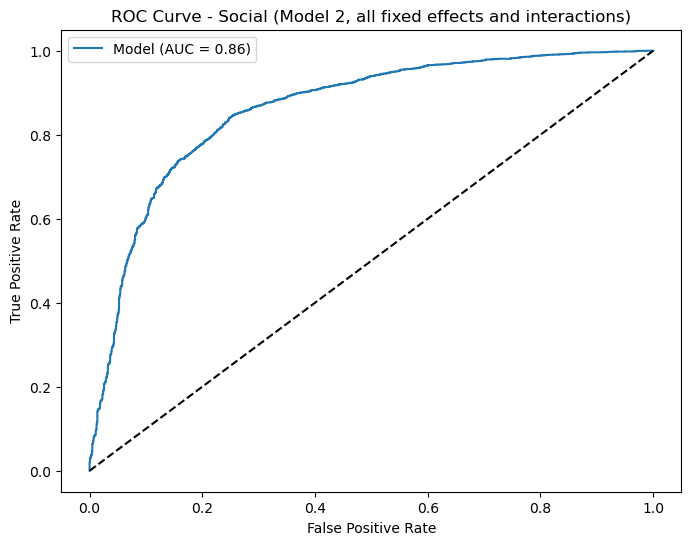

In [100]:
from sklearn.metrics import roc_curve, auc

# Example: Assuming `y_true` is the true labels and `y_scores` are model predictions
fpr, tpr, _ = roc_curve(ground_truth_data[5], prediction_data[5])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Social (Model 2, all fixed effects and interactions)')
plt.legend()
plt.show()

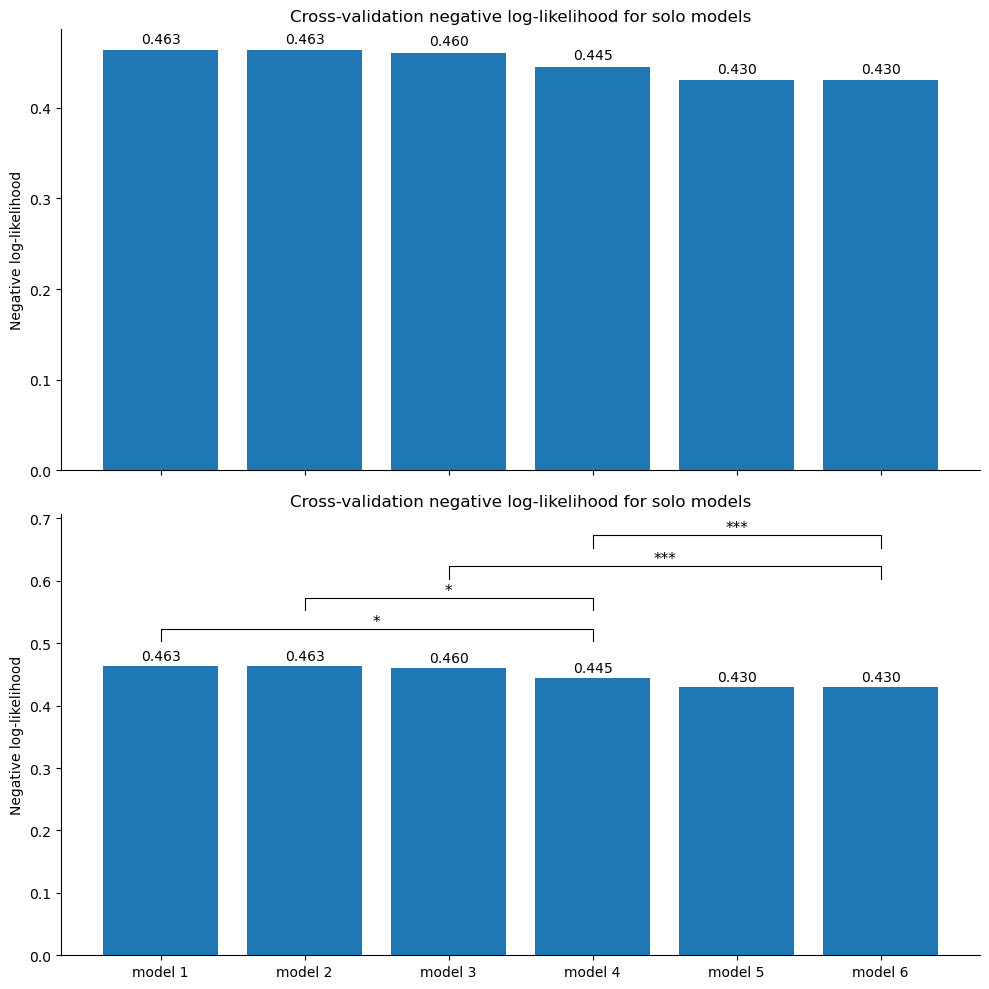

In [92]:
pairs = list(combinations(range(len(nlls)), 2))
num_comparisons = len(pairs)
# Bonferroni-corrected significance level
bonferroni_alpha = 0.05 / num_comparisons
title1 = 'Cross-validation negative log-likelihood for solo models'

results, pairs, bonferroni_alpha = run_pairwise_ttests(nlls, alpha=0.05)
plot_nlls_with_significance(average_nlls, plotting_names, results, pairs, bonferroni_alpha, title1, title2=title1)